<a href="https://colab.research.google.com/github/Cours-EDUlib/IVADO-RECM1FR/blob/main/fr_RSAE_QuestionsV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Recommandation de films à l'aide des auto-encodeurs
## IVADO - Cours en ligne sur les systèmes de recommandation

Le présent tutoriel est une adaptation du contenu initialement créé pour l'atelier sur les systèmes de recommandation d’IVADO en août 2019.

<b> Auteurs: </b>

David Berger 

Laurent Charlin 

Nissan Pow 

# 1. Introduction

Dans cet atelier, nous proposons d'implémenter un système de recommandation basé sur un auto-encodeur (AE), une architecture classique en apprentissage profond. Tout comme lors du volet de l'atelier portant sur les modèles utilisant la factorisation matricielle, nous utiliserons la base de données <a href="https://grouplens.org/datasets/movielens/">MovieLens</a> afin d'entraîner nos modèles, mener certaines expériences et comparer nos résultats avec d'autres types d'architectures.

## 1.1 Installation des librairies

Avant de commencer, nous devons nous assurer d'installer les librairies nécessaires pour le tutoriel à l'aide de `pip`.  Pour ce faire, exécutez la cellule suivante en la sélectionnant et en cliquant `shift`+`Enter`. Ceci peut prendre quelques minutes.

In [ ]:
!rm -rf RS-Workshop
!git clone https://github.com/davidberger2785/RS-Workshop

Cloning into 'RS-Workshop'...
remote: Enumerating objects: 49, done.
remote: Total 49 (delta 0), reused 0 (delta 0), pack-reused 49
Unpacking objects: 100% (49/49), done.


Afin de vous assurer que l'installation ait eu lieu, importez toutes les libraries et modules dont nous nous servirons pour cet atelier en exécutant la prochaine cellule.

In [ ]:
import numpy as np
import pandas as pd

# Data vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

# Homemade functions
sys.path += ['RS-Workshop/Tutoriels - En/']
import utilities as utl

Nous avons également écrit quelques fonctions passe-partout que nous avons regroupées dans la librairie `utilities`. En fait, ces différentes fonctions existent fort probablement déjà en python, mais nous en ignorons simplement l'existence...

## 1.2 Objectif

De façon générale, l'objectif d'un système de recommandation est, comme son nom l'indique, d'effectuer des recommandations personnalisées à chacun des utilisateurs. Idéalement, ces recommandations devront être bonnes, bien que ce concept puisse rapidement devenir flou. Contrairement à d'autres tâches en apprentissage automatique, telle la reconnaissance d'images de chats ou la prédiction du cours d'une action en bourse, effectuer des recommandations de manière à aider un utilisateur est d'autant plus complexe que ce problème est plus ou moins bien défini. Cherchons-nous à présenter à un utilisateur précis des suggestions le confortant dans ses choix antérieurs? Ou enconre, voulons-nous lui présenter des suggestions complémentaires ou totalement indépendantes des items précédemment considérés? Enfin, tenterons-nous plutôt de lui présenter des items auxquels il n'a pas encore été exposé? Chacune des ces options sont légitimes et pourront être modélisées. Sans perte de généralités, le schéma ci-dessous modélise simplement la problématique des systèmes de recommandation sous l'angle de l'apprentissage automatique.

![title](https://github.com/davidberger2785/RS-Workshop/blob/master/Images/High_level_1.png?raw=1)

N'empêche, dans le cadre de cet atelier et en considérant le contexte dans lequel nous sommes plongés, soit la suggestion de films comme le font Netflix ou Amazon Prime, nous pouvons réduire le problème à une tâche relativement simple: recommander des films que l'utilisateur va aimer en fonction de ses intérêts passés. Afin de mener à bien cette tâche, nous utiliserons l'ensemble des préférences des usagers, certaines variables sociodémographiques associées de même que certaines caractéristiques des films. Enfin, nous pouvons rafiner le schéma ainsi: 

![title](https://github.com/davidberger2785/RS-Workshop/blob/master/Images/High_level_2.png?raw=1)


## 1.3 Jeu de données  - MoviesLens 100k

Les données que nous allons manipuler afin d'explorer différents types de systèmes de recommandation sont celles associées au projet <a href="https://grouplens.org/datasets/movielens/"> MovieLens</a>. Brièvement, les données utilisées consistent ici en plus ou moins 100 000 évaluations de films effectuées par 943 utilisateurs et où un ensemble de 1 682 films étaient disponibles en visionnement. En plus des 100 000 évaluations à notre disposition, nous avons des informations complémentaires liées à chacun des usagers de même qu'à chacun des films.

En somme, nous allons utiliser un total de trois jeux de données afin de mener à bien nos analyses soit: 

<ul>
<li> Users : contenant des informations associées aux caractéristiques des utilisateurs,
<li> Movies : contenant des informations associées aux caractéristiques des films en visionnement,
<li> Ratings : contenant l'ensemble des 100 000 évaluations effectuées par les utilisateurs.
</ul>

Nous utiliserons la librairie <a href="https://pandas.pydata.org/">Pandas</a> pour télécharger la base de données.

### 1.3.1 Users: Importation et prétraitement des données

In [ ]:
# Téléchargement des données
ROOT_DIR = 'RS-Workshop/'
DATA_DIR = os.path.join(ROOT_DIR, 'data/ml-100k/')

users = pd.read_csv(os.path.join(DATA_DIR, 'u.user'), 
                        sep='|', header=None, engine='python', encoding='latin-1')
# Nous définissons les différentes variables en fonction de l'information fournie dans le fichier 'readme'
users.columns = ['Index', 'Age', 'Gender', 'Occupation', 'Zip code']

# Bref aperçu
users.head()

,Index,Age,Gender,Occupation,Zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Avant de présenter les statistiques descriptives liées à la population étudiée, nous allons dans un premier temps traiter les données associées aux usagers sous la forme d'une <a href="https://fr.wikipedia.org/wiki/Liste_(informatique)">liste</a> afin de pouvoir plus aisément les manipuler. Notons que l'occupation de chaque individu étant une chaîne de caractères, nous avons recodé les 21 occupations possibles en booléen.

In [ ]:
# Nombre d'utilisateurs et d'utilisatrices
nb_users = len(users)

# Sexe
gender = np.where(np.matrix(users['Gender']) == 'M', 0, 1)[0]

# Occupation
occupation_name = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u.occupation'), 
                                            sep='|', header=None, engine='python', encoding='latin-1').loc[:, 0])

# Recodage en booléen de la variable occupation
occupation_matrix = np.zeros((nb_users, len(occupation_name)))

for k in np.arange(nb_users):
    occupation_matrix[k, occupation_name.tolist().index(users['Occupation'][k])] = 1

# Concatenation des différentes données sociodémographiques sous forme de liste
user_attributes = np.concatenate((np.matrix(users['Age']), np.matrix(gender), occupation_matrix.T)).T.tolist()

Nous explorons par la suite les différentes statistiques descriptives associées aux usagers. Celles-ci comportent des informations en lien avec l'âge (variable continue), le sexe (variable binaire) et l'occupation de chacun des usagers (au nombre de 21, toutes binaires). 

Statistiques descriptives associées à l'âge.

In [ ]:
pd.DataFrame(users['Age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Age,943.0,34.051962,12.19274,7.0,25.0,31.0,43.0,73.0


Diagramme à bandes pour la stastistique associée au sexe.

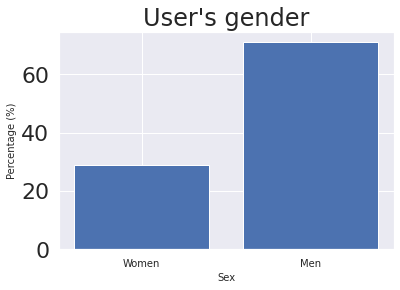

In [ ]:
utl.barplot(['Women', 'Men'], np.array([np.mean(gender) , 1 - np.mean(gender)]) * 100, 
            'Sex', 'Percentage (%)', "User's gender", 0)

Diagramme à bandes pour la stastistique associée à l'occupation des individus.

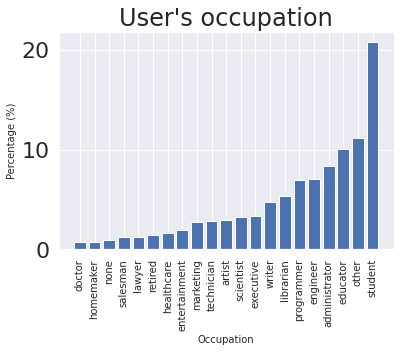

In [ ]:
attributes, scores = utl.rearrange(occupation_name, np.mean(occupation_matrix, axis=0) * 100)
utl.barplot(attributes, scores, 'Occupation', 'Percentage (%)', "User's occupation", 90)

### 1.3.2 Movies: Importation et reformatage des données

De la même façon, nous allons traiter et explorer les données associées aux films. Pour chacun d'eux, nous disposons du titre, de la date de sortie en Amérique du Nord, de même que les genres auxquels il est associé.

In [ ]:
movies = pd.read_csv(os.path.join(DATA_DIR, 'u.item'), sep='|', header=None, engine='python', encoding='latin-1')

# Number of movies
nb_movies = len(movies)

# Genres
movies_genre = np.matrix(movies.loc[:, 5:])
movies_genre_name = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u.genre'), sep='|', header=None, engine='python', encoding='latin-1').loc[:, 0])

# Quick overview
movies.columns = ['Index', 'Title', 'Release', 'The Not a Number column', 'Imdb'] + movies_genre_name.tolist()
movies.head()

,Index,Title,Release,The Not a Number column,Imdb,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Nous présentons les proportions de films en fonction du genre comme statistique descriptive.

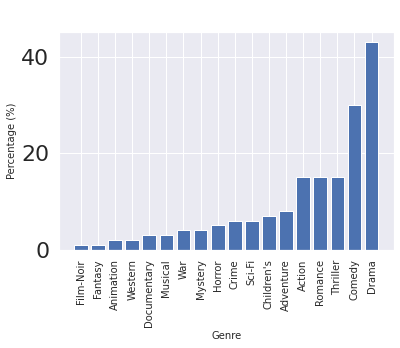

In [ ]:
attributes, scores = utl.rearrange(movies_genre_name, 
                                   np.array(np.round(np.mean(movies_genre, axis=0) * 1, 2))[0])
utl.barplot(attributes, np.array(scores) * 100, xlabel='Genre', ylabel='Percentage (%)', 
            title=" ", rotation = 90)

### 1.3.3 Ratings: Importation et traitement des données

La base de données comportant les évaluations des films effectuées par les usagers est constituée d'environ 100 mille lignes (une évaluation par ligne) où sont respectivement recensés le numéro d'identification de l'utilisateur, le numéro d'identification du film, l'évaluation associée et un marqueur de temps auquel le film a été visionné. Les ensembles d'entraînement et de test ont été fournis tels quels, c'est-à-dire que nous n'avons pas besoin de les construire nous-même, et comportent respectivement 80 et 20 mille évaluations.

Pour des raisons pratiques, nous convertissons la base de données sous la forme d'une liste grâce à la fonction maison `convert`. 

In [ ]:
training_set = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u1.base'), delimiter='\t'), dtype='int')
testing_set = np.array(pd.read_csv(os.path.join(DATA_DIR, 'u1.test'), delimiter='\t'), dtype='int')

train_set = utl.convert(training_set, nb_users, nb_movies)
test_set = utl.convert(testing_set, nb_users, nb_movies)

Comme nous l'avons fait auparavant, nous pouvons obtenir quelques statistiques descriptives associées aux évaluations. Dans une premier temps, il pourrait être intéressant d'étudier les tendances moyennes des individus.

##### Question 1

1. Quelles autres types de statistiques pourraient être intéressantes?

##### Réponse 1

1. Nous pourrions définir les différentes statistiques co-dessous en fonction d'autres attributs, tel le sexe des usagers, leur occupation ou encore leur âge.

In [ ]:
train_matrix = np.array(train_set)
shape = (len(train_set), len(train_set[0]))
train_matrix.reshape(shape)
train_matrix_bool = np.where(train_matrix > 0 , 1, 0)

user_watch = np.sum(train_matrix_bool, axis=1)
pd.DataFrame(user_watch).describe().T

,count,mean,std,min,25%,50%,75%,max
0,943.0,84.834571,83.805787,4.0,27.0,50.0,115.0,685.0


Avec un petit histogramme...

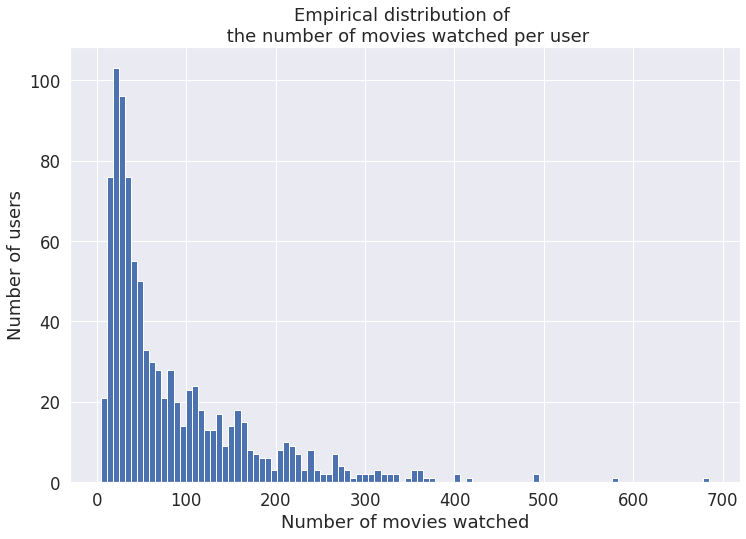

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale = 1.5)

plt.title('Empirical distribution of \n the number of movies watched per user')
plt.xlabel('Number of movies watched')
plt.ylabel('Number of users')
plt.hist(user_watch, 100);

Nous présentons finalement quelques statistiques associées aux films.

In [ ]:
movie_frequency = np.mean(train_matrix_bool, axis=0)
pd.DataFrame(movie_frequency).describe().T

,count,mean,std,min,25%,50%,75%,max
0,1682.0,0.050437,0.068664,0.0,0.005302,0.022269,0.066808,0.513256


##### Question 2

1. Quelles statistiques ou observations pourraient nous paraître pertinentes? Pourquoi? 
2. Quel type de statistique pourrait être plus approprié dans un tel contexte?

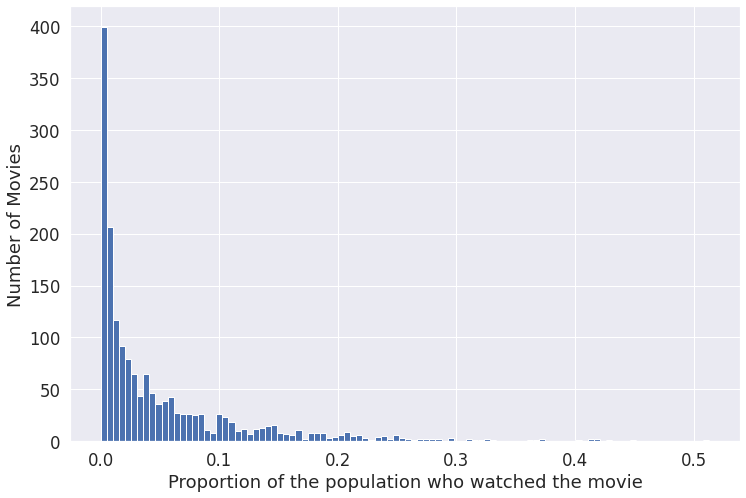

In [ ]:
plt.xlabel('Proportion of the population who watched the movie')
plt.ylabel('Number of Movies')
plt.hist(movie_frequency, 100);

#### Étude des préférences individuelles en fonction du type de film

Nous pourrions également nous intéresser au comportement d'un individu en particulier. Entre autres choses, nous pourrions étudier s'il y a un biais associé à son schème d'évaluation ou encore quelles sont ses préférences cinématographiques en fonction du score attribué.

In [ ]:
def stats_user(data, movies_genre, user_id):
    
    ratings = data[user_id]
    stats = np.zeros(6)
    eva = np.zeros((6, movies_genre.shape[1]))

    for k in np.arange(len(ratings)):
        index = int(ratings[k])
        stats[index] += 1
        eva[index, :] = eva[index, :] + movies_genre[k]

    return stats, eva

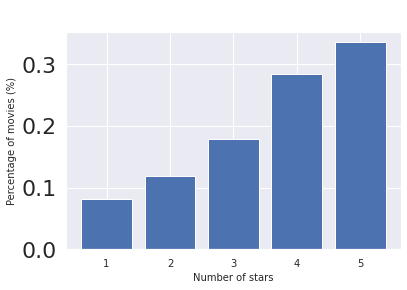

In [ ]:
user_id = 0
stats, eva = stats_user(train_set, movies_genre, user_id)
utl.barplot(np.arange(5) + 1, stats[1:6] / sum(stats[1:6]), xlabel='Number of stars', ylabel='Percentage of movies (%)', 
            title=" ", rotation = 0)

##### Question 3

1. Comment vérifier qu'il existe un biais associé au schème d'évaluation d'un individu?

## 1.4 Création des sous-ensembles d'entraînement et de validation

En apprentissage automatique, nous manipulons des <a href="https://blogs.nvidia.com/blog/2018/04/15/nvidia-research-image-translation/">bases de données complexes</a> pour lesquelles nous tentons de définir des espaces de fonctions tout aussi complexes dans le but d'accomplir une tâche précise. Ceci étant, ces espaces de fonctions sont définis par un ensemble de paramètres dont le nombre tend à augmenter avec la complexité des données. Une fois l'espace défini par un ensemble de paramètres fixés, nous pouvons varier les différentes valeurs d'hyperparamètres afin d'explorer empiriquement les espaces de fonctions. Pour choisir l'ensemble des paramètres et d'hyperparamètres optimaux, nous définissons une métrique nous permettant d'évaluer le modèle; par exemple, à quel point l'image d'un chat nous paraît vraisemblable. 

Dans la mesure où nous voulons développer un modèle capable de généraliser, l'évaluation de ses performances, et donc la sélection des (hyperparamtètres) doit se faire sur un ensemble de données indépendant, mais issues de la même distribution, de l'ensemble sur lequel il a appris. Pareil ensemble porte le nom d'ensemble de validation.

<b>! Remarque !</b> 

La notion d'ensemble d'entraînement et de test dans le cadre de système de recommandation est quelque peu différente de ce que l'on voit habituellement avec les problèmes dits supervisés. Si dans le cadre d'un problème supervisé, l'ensemble de test consiste essentiellement en de nouvelles observations (lire lignes d'un fichier) indépendantes des observations préalablement observées dans l'ensemble d'entraînement, le paradigme est sensiblement différent lorsque nous travaillons avec des systèmes de recommandation.

Effectivement, et en raison du modèle mathématique sur lequel est basé les systèmes de recommandation, les données appartenant à l'ensemble de test ne sont pas liées à un nouvel individu, mais bien à de nouvelles évaluations, faites par le même ensemble d'individus, mais jusqu'alors inobservées. Dès lors, les données associées aux ensembles d'entraînement, de validation et de test ne sont plus indépendantes tel que supposé (la fameuse hypothèse <i> iid </i>); ce qui complique théoriquement les choses.

Puisque le but de l'atelier n'est pas d'étudier la notion de biais associée au type de dépendance entre les différents évaluations dans les systèmes de recommendation, nous allons naïvement supposer que chacune des évaluations sont indépendantes les unes des autres. N'empêche, dans un cadre pratique, ignorer ce genre de considérations pourra éventuellement biaiser les algorithmes.

In [ ]:
def split(data, ratio, tensor=False):
    train = np.zeros((len(data), len(data[0]))).tolist()
    valid = np.zeros((len(data), len(data[0]))).tolist()

    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] > 0:
                if np.random.binomial(1, ratio, 1):
                    train[i][j] = data[i][j]
                else:
                    valid[i][j] = data[i][j]

    return [train, valid]

train = split(train_set, 0.8)
test = test_set

# 2. Système de recommandation: Auto-encodeur

## 2.1 Modèle

## 2.1 Modèle

De façon générale, les auto-encodeurs sont une classe de réseaux de neurones permettant d'effectuer l'apprentissage non supervisé des caractéristiques latentes des données à l'étude. Pour ce faire, l'AE tentera de prédire, ou copier, les observations en entrée à l'aide de (multiple) couche cachée. Dans sa plus simple expression, l'architecture d'un AE peut se résumer au schéma ci-dessous.

![title](https://github.com/davidberger2785/RS-Workshop/blob/master/Images/AE.png?raw=1)

En regardant de plus près, l'AE consiste en un encodeur, soit la fonction $h(\cdot)$ définie par:

$$
\begin{align}
    h(\mathbf{x}) = \frac{1}{1+ \exp(-\mathbf{W} \mathbf{x})}.
\end{align}
$$

Cette fonction prend en entrée les observations et consistera à la recoder sous forme d'une couche cachée de façon telle à réduire leur dimension (moins de neurones). Par après, un encodeur défini par:

$$
\begin{align}
    f(h(\mathbf{x})) = \mathbf{W}^\top h(\mathbf{x})
\end{align}
$$

tentera de <i>reconstuire</i> les observations présentées en entrée à partir de la couche cachée. En ce sens, l'AE cherche à estimer les observations utilisées en entrée.

Nous pouvons avantageusement utiliser les estimations faites par les auto-encodeurs de façon telle à présenter de nouvelles recommandations aux usagers. 

Par exemple, supposons que l'ensemble des évaluations effectuées par un usager est défini par le vecteur:

$$
\begin{align}
    \mathbf{x} = [3, \ 0, \ 0, \ 1, \ ..., \ 2, \ 4].
\end{align}
$$

Nous remarquons que le film en première position, soit <i> Toy Story </i>, a été moyennement apprécié, alors que les deux films suivant, <i>Golden eye</i> et <i>Four rooms</i>, n'ont pas été visionnés. Supposons encore une fois qu'à ce même ensemble d'évaluations, l'AE présentera les estimations suivantes:

$$
\begin{align}
    \mathbf{\hat{x}} = [3.2, \ 1.3, \ 4, \ 0.5, \ ..., \ 3, \ 1].
\end{align}
$$

Dès lors, nous pourrons utiliser les estimations associées aux films initiallement non visionnés comme autant de recommandations. Ainsi, le film <i>Four rooms</i>, en troisième position, semble une bonne suggestion pour l'usager, alors que <i>Golden eye</i> n'est définitivement pas un recommandation probante.

## 2.2 L'apprentissage profond avec Pytorch

Afin de construire un système de recommandation basé sur les AE, nous allons utiliser la librairie 
<a href="https://pytorch.org/"> `Pytorch`</a>.  Cette libraire fournit deux fonctionnalités extrêmement intéressantes:
<ul>
<li> Manipulation de tenseurs (matrices à plusieurs dimensions) permettant d'effectuer les calculs avec GPU.</li>
<li> Utilisation de la différentiation automatique avec la classe <a href="http://pytorch.org/docs/master/autograd.html"> autograd</a> permettant de calculer facilement la descente de gradient. </li>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

from torch.nn import functional
from torch.autograd import Variable

Puisque nous travaillerons avec Pytorch, transformons les données de MoviesLens en objet tensoriel.

In [ ]:
train = torch.FloatTensor(train_set)
train, valid = train[0], train[1]
test = torch.FloatTensor(test_set)

**! Remarque !** 

Bien que la documentation disponible pour Pytorch soit détaillée (comparativement à d'autres librairies en apprentissage profond), il est facile de s'y perdre. N'empêche, pour la suite de l'atelier, il n'est pas nécessaire de saisir la totalité des nuances associées aux différentes commandes. En fait, l'essentiel est plutôt de bien saisir les tenants et aboutissants des étapes clés présentées.

## 2.3 Implémentation

Nous pouvons décliner en cinq étapes l'implémentation d'un AE comme système de recommandation:

1. Initialisation de l'AE,
2. Propagation message,
3. Estimation:  calcul du coût et rétro propagation,
4. Boucle d'apprentissage,
5. Évaluation. 

### 2.3.1 Initialisation

Dans un premier temps, nous définissons la classe de l'auto-encodeur à l'aide de la classe <a href="http://pytorch.org/docs/master/nn.html#module">torch.nn.Module</a>. En PyTorch, tout réseau de neurones doit hériter de cette classe. La classe d'auto-encodeur que nous définierons fait appel à d'autres classes communes dans Pytorch, telle <a href="http://pytorch.org/docs/master/nn.html#torch.nn.Linear">torch.nn.Linear(in_features, out_features)</a>. Cette dernière  implémente une couche linéaire (comme son nom l'indique) et complétement connectée prenant par défaut deux paramètres, soit l'entrée (in_features) et la sortie (out_features).  

##### Question 4

1. Complétez l'initialisation de la classe d'auto-encodeur conformément au schéma de l'architecture présenté ci-dessus.

In [ ]:
class AE(nn.Module):
    def __init__(self, nb_inputs, nb_outputs, nb_features, criterion=None):
        """
        Args:
            self: nom de la classe
            nb_inputs: nombre neurones sur la couche d'entrée
            nb_outputs: nombre neurones sur la couche de sortie
            nb_features: nombre de neurones sur la couche cachée
            criterion: fonction de perte utilisé pour l'apprentissage    
        """
        super(AE, self).__init__()

        # Complétez ici
        # Et là
        
        self.criterion = criterion

La classe maintenant définie, nous définierons:

1. Le nombre de neurones en entrée,
2. Le nombre de neurones en sortie,
3. Le nombre de neuronnes désirés dans la couche cachée. 

##### Question 5

1. Initialisez l'auto-encodeur avec les bonnes valeurs de paramètres.
2. Est-ce pertinent que la couche cachée ait plus de neurones que la couche d'entrée?

In [ ]:
nb_inputs = ?
nb_outputs = ?
nb_features = ?

# Ininitalisation 
ae = AE(?)

SyntaxError: ignored

### 2.3.2 Propagation

Lors de la phase de propagation, la fonction `forward` associée à la propagation du message définit les opérations à effectuer afin de calculer les éléments de la sortie. Cette fonction est indispensable, porte par défault le nom `forward` et doit concorder avec l'initialisation du modèle lors de l'étape précédente afin de permettre une rétropropagation adéquate.
   
Notons également l'utilisation de la méthode <a href="http://pytorch.org/docs/master/nn.html#torch-nn-functional">torch.nn.functional</a> définissant un ensemble de fonctions qui peuvent être appliquées aux couches d'un réseau de neurones. Dans le cadre de cet atelier, nous utiliserons des fonctions non-linéaires comme <a href="http://pytorch.org/docs/master/nn.html#id36">sigmoid</a> et des fonctions de coût tel l'erreur quadratique moyenne <a href="http://pytorch.org/docs/master/nn.html#mse-loss">mse_loss</a>.

##### Question 6

1. Complétez la fonction `forward`.

In [ ]:
def forward(model, x):
    """
    Args: 
        model: nom de l'auto-encodeur tel qu'initialisé
        x: couche d'entrée, ici composée de 1682 neurones
    Return: 
        predictions: la couche de sortie
    """
    
    # ...
    
    return ?

### 2.2.2 Estimation des poids

Bien que les réseaux de neurones présentent notamment dans capacités prédictives ahurissantes, la complexité de leur archicture peut s'avérer rapidement très grande. D'un point de vue calculatoire, cela se traduit entre autres choses par l'impossibilité d'obtenir un optimum global pour la fonction de coût et bien sûr, d'estimer la valeur des poids de façon analytique, comme cela peut être fait dans un modèle linéaire sous hypothèse de normalité. N'empêche, si aucun optimum global n'est garanti, et si accessoirement aucune forme analytique ne peut être calculée, il n'en demeure pas moins que les poids associés peuvent être estimés. 

En ce sens, la descente (stochastique) du gradient (et ses dérivées) est une technique d'optimisation efficace et largement mise de l'avant en apprentissage profond. Cette technique fait appel à trois concepts clés, soit:

1. La fonction de coût.
2. Le type d'optimisateur.
3. La rétropropagation du gradient (implémentée dans la boucle d'apprentissage)

#### 2.2.2.1 Fonction de coût

Comme nous l'avons vu lors du précédent atelier, la fonction de coût joue un rôle déterminant dans la construction d'un modèle prédictif. En effect, c'est cette même fonction de coût que nous essaierons de minimiser (ou maximiser c'est selon) en ajustant itérativement les poids de l'AE au fur et à mesure que nous lui fournirons des évaluations. Ainsi, deux fonctions de coût différentes entraîneront fort probablement deux modèles différents. Comme d'habitude, Pytorch propose une grande quantité  de <a href="http://pytorch.org/docs/master/nn.html#id42"> fonctions de coût</a> que vous pourrez explorer à votre guise.

Dans la mesure où l'on considère que les évaluations varient entre 1 et 5, l'erreur quadratique moyenne (EQM) semble une première option intéressante. Formellement, dans le cadre d'un système de recommandation, nous définierons l'EQM ainsi : 

$$
\begin{align}
EQM (\mathbf{R}, \hat{\mathbf{R}}) = \frac{1}{n} \sum_{r_{ui} \neq 0} (r_{ui} - \hat{r}_{ui})^2, 
\end{align}
$$

où $\mathbf{R}$ et $\hat{\mathbf{R}}$ sont respectivement les matrices des évaluations observées et prédites, $n$ est le nombre total d'estimations effectuées. De la même façon, $r_{ui}$ et $\hat{r}_{ui}$ sont des scalaires associés respectivement à l'évaluation observée et l'évaluation estimée de l'usager $u$ pour l'item $i$.

Puisque nous avons codé la fonction de coût comme étant un attribut de la classe des auto-encodeurs, nous pouvons la définir avec la commande suivante.

In [ ]:
ae.criterion = nn.MSELoss()

##### Question 7

1. Si l'EQM nous semble une fonction de coût intéressante dans le cas de système de recommandation avec des données explicites, quelle fonction de coût pertinente aurait pu être implémentée si les données avaient été implicites (évaluations binaires en fonction des préférences)? 

#### 2.2.2.2 Optimiseur

PyTorch fournit plusieurs <a href="http://pytorch.org/docs/master/optim.html#algorithms"> méthodes d'optimisation</a> plus ou moins dérivées de la descente du gradient via la classe `torch.optim`. Parmi ces techniques, nommons: 
<ul>
<li> SGD (Descente Stochastique du Gradient) : implémentation de SGD.
<li> Adam (Adaptive Moment Estimation) : variation de la méthode de descente de gradient où le taux d'apprentissage est ajusté pour chaque paramètre.     
<li> RMSprop : fonction de coût adaptée aux systèmes de recommandations. Plus de détails <a href="http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf">ici</a>.
</ul>

Dans tous les cas, lorsque nous utilisons des méthodes d'optimisation itératives, nous devons fournir un pas d'apprentissage (learning rate) et une contrainte sur les poids, pour des raisons similaires à celles évoquées lors du précédent atelier. 

In [ ]:
learning_rate = 0.02
weight_decay = 0.2

optimizer = optim.RMSprop(ae.parameters(), lr=learning_rate, weight_decay=weight_decay)

#### 2.2.2.3 Rétropropagation du gradient

En Pytorch, la rétropropagation du gradient est simplifiée grâce à la différentiation automatique du gradient et de la classe <a href="http://pytorch.org/docs/master/notes/autograd.html">autograd</a>. Celle-ci se fait en deux temps:

1. Calcul de la fonction de coût avec la fonction définie au préalable dans la classe de l'AE.
2. Dérivation automatique de la fonction de coût grace à la fonction `backward()`.

L'ensemble du processus de rétropropagation est directement implémenté dans la boucle d'apprentissage définie ci-dessous.

### 2.2.3 Boucle d'apprentissage

Lorsqu'un auto-encodeur (et de façon générale une architecture basée sur l'apprentissage profond) est utilisé comme système de recommandation, la boucle d'apprentissage diffère quelque peu de celle associée aux modèles basés sur la factorisation matricielle. Ainsi, chaque évaluation n'est plus considérée de façon individuelle, comme c'était le cas auparavant, mais est ici considérée sur l'ensemble des évaluations fournies par un individu donné par exemple.

##### Question 8

1. Complétez la phase de propagation.
2. À la fin de chaque époque, quelle statistique serait-il préférable de calculer? Codez-la. Remarque : il est préférable d'initialiser des objets en début de fonction (voir ligne 6)
3. Implémentez la phase de rétropropagation.
4. Dans la mesure où des données issues de l'ensemble d'entraînement, de validation ou de test peuvent être utilisées dans la fonction fit, quelles condition devrions-nous mettre à la ligne 22?

In [ ]:
def fit(model, x, y, valid=False):
    """
    Args:
        model: nom de l'auto-encodeur tel qu'initialisé
        x: entrées
        y: sorties
        valid: variable booléene nous permettant de dire si on veut ajuster les poids du modèle ou nom
    Returns:
        model: le modèle d'AE, entraîné ou pas
        average_loss: scalaire associée à la fonction de perte
        s: compteur du nombre d'observations en terme de x
    """
    
    nb_obs, nb_items = len(x), len(x[0])
    average_loss, s = 0, 0.

    for id_user in range(nb_obs):

        inputs = Variable(x[id_user]).unsqueeze(0)
        target = Variable(y[id_user]).unsqueeze(0)

        if torch.sum(target > 0) > 0:
            
            # Question 8.1: Phase de propagation
            #estimate = ?
            #
            target.require_grad = False
            
            # Question 8.3: Phase de rétropropagation
            # loss = ?
            
            # Question 8.4: Condition
            if ?:
                #loss.backward()
                #optimizer.step()

            # Question 8.2: Statistique à calculer
            #
            s += 1.

    return model, average_loss, s

## 2.4 Entraînement de l'AE

L'auto-encodeur et les fonctions associées maintenant implémentés, nous pouvons commencer à entraîner le modèle. Encore une fois, le but ici n'est pas d'ajuster les paramètres de façon telle à obtenir le meilleur modèle possible, mais simplement de comprendre le rôle que ceux-ci peuvent jouer en fonction de leur capacité prédictive. 

##### Question 9

1. Finissez d'implémenter la phase d'entraînement.

In [ ]:
nb_epoch = 20

for epoch in range(1, nb_epoch + 1):
    
    # ...
    
    print("epoch: ", "{:3.0f}".format(epoch), "   |   train: ", "{:1.8f}".format(train_loss.numpy() / train_s), \
                    '   |   valid: ', "{:1.8f}".format(valid_loss.numpy() / valid_s))

Vous pouvez maintenant manipuler les différents paramètres et hyperparamètres de l'AE. Parmi les différentes modifications que vous pouvez apporter, voici une (courte et non exhaustive) liste des modifications facilement implémentables:

1. Changer les hyperparamètres (un peu plate).
2. Augmenter la taille de la couche cachée (plus intéressant).
3. Ajouter des couches cachées au modèle en prenant soin de bien les initialiser et d'adapter la fonction forward.
4. Dichotomiser les données à l'aide d'un seuil (par exemple 3) et rouler l'ensemble du code en adaptant ou pas la fonction de coût tel que discuté précédemment.

Enfin, nous pouvons évaluer les performances de notre modèle sur l'ensemble test.

In [ ]:
ae, test_loss, test_s = fit(model=ae, x=test, y=test, valid=True)
print('test: ', np.around(test_loss.numpy() / test_s, 4))

## 2.5 Analyse


### 2.5.1 Exploration de la couche latente

De façon analogue à ce qui a été présenté dans l'atelier sur la factorisation matricielle, nous pouvons explorer la couche latente de l'AE. Dans la mesure où la couche d'entrée représente l'ensemble des évaluations pour un individu donnée, chaque neurone de la couche latente sera associé à un attribut latent d'un individu.

À titre d'exemple, posons $\mathbf{H}_{|U| \times k}$ la matrice associée à la couche la tente où chaque ligne représente la représentation latente des préférences pour un usager donné et où chaque colonne représente un neurone de cette même couche. Supposons maintenant que les deux premiers neurones de la couche latente  présentent les valeurs suivantes: 

$$
\begin{align}
h_1 &= [1.0, \ 0.0, \ -0.5, \ ..., \ 1.0, \ -1.0 ] 
\qquad \text{et} \qquad
h_2 = [1.0, \ 0.0,  \ 0.5, \ ..., \ -1.0, \ -0.8 ].
\end{align}
$$

Et qu'à ces valeurs correspondent les usagers suivant: 

1. Serena,
2. Kali,
3. Neil,
4. Marie,
5. David.

Nous pourrons dès lors cartographier les usagers en fonction des valeurs associées à $h_1$ et $h_2$:

![title](https://github.com/davidberger2785/RS-Workshop/blob/master/Images/hidden_4.png?raw=1)

Cette façon de faire pourrait nous permettre d'effectuer des grappes d'individus en fonction des attributs latents. En fait, un rapide coup d'oeil nous permet de penser que les préférences en terme de cinéma de Serena sont à l'opposé de David, ce qui n'a rien de bien surprenant.

Avec les commandes suivantes, nouus proposons d'explorer davatange la structure latente de l'AE.

In [ ]:
x = train
hidden = torch.sigmoid(ae.fc1(x)).detach().numpy()

Bien que cette information nous semble informe, nous pourrions nous intéresser, par exemple, aux mesures d'association entre les différentes couches cachées, ou encore une couche cachée et une des caractéristiques sociodémographiques. Pour ce faire, une avenue intéressante serait de simplement calculer les corrélations associées.

In [ ]:
df = pd.DataFrame(np.array(hidden))

f = plt.figure(figsize=(6, 6))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=10, rotation=0)
plt.yticks(range(df.shape[1]), df.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)

Premièrement, en explorant simplement les corrélations entre les différents neurones.

##### Question 10

1. Quel neurone de la couche cachée vous semble <i>a priori</i> le plus intéressant? Pourquoi?

##### Question 11

1. L'étude de la couche latente s'est faite ici en fonction des utilisateurs du système. Serait-il possible d'étudier les couches latentes associées aux individus. Si oui, comment?

# 3. Applications

L'un des objectifs premier des systèmes de recommandation est d'effectuer de recommandations (!) personnalisées pour chacun des utilisateurs. Dès lors, il pourrait être intéressant d'étudier les recommandations effectuées par notre modèle pour un individu spécifique. Il serait également préférable que les recommendations faites ne suggèrent que des films non visionnés par l'usager.

##### Question 12

1. Implémentez une courte fonction afin d'effectuer les <i>k</i> meilleures recommandations de films n'ayant pas encore été visionnés pour un usager choisi.

In [ ]:
def recommendations(model, data, titles, k):
    """
    Args:
        model: nom de l'auto-encodeur tel qu'initialisé
        data: les évaluations associées à l'usager
        titles: listes de titres des objets potentiellement recommandés
        k: nombre de recommandations voulues
    Return:
        names: titres des recommandations
        scores: le score qui leur est associé
    """

    # ...
    
    return ?

Appel de la fonction avec quelques manipulations...

In [ ]:
user_id = 0
k=10

names, scores = recommendations(?)

Comme nous l'avons vu lors de l'atelier portant sur les systèmes de recommandation basés sur la factorisation matricielle, nous pouvons facielement personnaliser les algorithmes en fonction de plusieurs paramètres. À titre d'exemple, nous pourrions implémenter un systèmes proposant les meilleures recommandations en fonction:

1. D'un genre de film en particulier.
2. D'une préférence minimale souhaitée: un score minimal prédit strictrement supérieur à 4,5 par exemple.

##### Question 13

1. Est-ce que les recommandations faites pour un même usager sont les mêmes d'un algorithme à l'autre?

# 4. Autres idées de modélisations

Jusqu'à présent, nous n'avons considéré que les évaluations dans notre modèle. Il pourrait être intéressant de considérer d'autres types de modélisations. 

Par exemple, au lieu d'utiliser les évaluations de films fait par un individu comme couche d'entrée (donc 1682 neurones), nous pourrions utiliser les évaluations des individus pour un film en particulier (et donc 943 neurones en couches d'entrée). Dans la même veine, à cette modélisation, nous pourrions incorporer les différents genre des films et/ou leur année de sortie.

Enfin, nous pourrions simplement nous détacher des auto-encodeurs et lorgner d'autres types d'architectures. En considérant les différentes fonctions et classe précédement codées, nous pourrions implémenter un perceptron multicouche. Pour ce faire, les entrées du réseaux seraient exactement les mêmes, à la différence que les cibles ne seraient constituées que de films non visionnés.

## 4.1 Utilisation des données sociodémographiques

Il pourrait être intéressant de vérifier si l'utilisation des données sociodémographiques des usagers améliore ou non les capacités prédictives du modèle. En fait, dans la mesure où pareilles informations n'amélioreraient que très peu les capacités du modèle, elles pourraient être utiles lorsqu'un nouvel usager compte utiliser le système de recommandation mis en place. Bien qu'imparfaites, les informations associées à l'âge, le genre et l'occupation d'un usager pourraient être utiles pour présenter les premières recommendations.

Afin d'observer comment l'AE se comporte avec de telles données, nous devons dans un premier temps modifier les différents ensembles afin que ceux-ci présentent les informations sociodémographiques de chaque usager.

In [ ]:
train_inputs = torch.FloatTensor(utl.inner_concatenation(user_attributes, train_set[0]))
train_outputs = torch.FloatTensor(train_set[0])

valid_inputs = torch.FloatTensor(utl.inner_concatenation(user_attributes, train_set[1]))
valid_outputs = torch.FloatTensor(train_set[0])

test_inputs = torch.FloatTensor(utl.inner_concatenation(user_attributes, test_set))
test_outputs = torch.FloatTensor(test_set)

##### Question 14

1. Initialisez l'auto-encodeur.

##### Question 15

1. Implémentez la phase d'entraînement.

##### Question 16

1. Calculez les performances sur l'ensemble test.

### 4.1.1 Problème du démarrage à froid

En fait, et tel que mentionné précédemment, au-delà d'améliorer les performances du modèle en fonction de la métrique choisie, l'incorporation de variables sociodémographiques dans le modèle permet d'effectuer des recommandations à un nouvel utilisateur simplement en fonction de ses attributs. Cette modélisation permet de contrecarrer le problème de démarrage à froid ou mieux connu sous le nom de <i>cold start</i>.

##### Question 17

1. Fixer l'âge, le genre et l'occupation d'un individu.
2. Considérer que ce-dernier n'a encore évaluer aucun film.
3. Présentez-lui, selon le modèle estimée, les meilleures recommandations de films.
4. Faites varier les attributs de l'individus.
5. Que remarquez-vous?

In [ ]:
# Question 17.1: Fixez les attributs d'un individu
age = [10]
gender = [1]

occupation = np.zeros(len(occupation_name))
occupation_name = np.array(pd.read_csv('../data/ml-100k/u.occupation', 
                                            sep='|', header=None, engine='python', encoding='latin-1').loc[:, 0])

occupation[occupation_name.tolist().index('artist')] = 1

# Question 17.2: Aucun film


# Question 17.3: Meilleures recommandations
